# Лабороторная работа: Алгоритм Гриффина-Лима
### Кодуков А.В. 9385

C:\Users\akodu\AppData\Local\Temp\ipykernel_23604\164347608.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


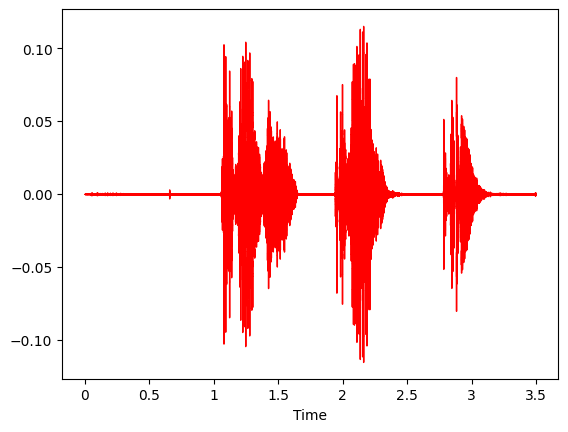

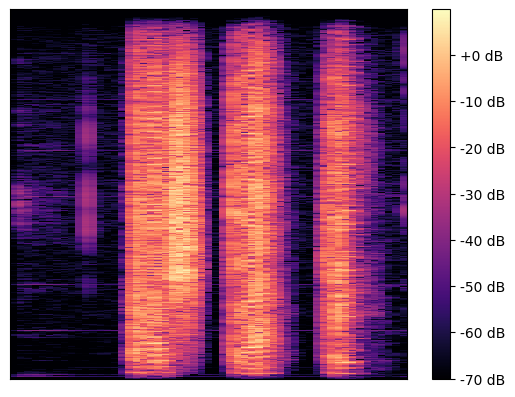

In [102]:
import librosa
import numpy as np
from matplotlib import pyplot as plt

X, fd = librosa.load('voice_16k.mp3', sr=16000)
X, _ = librosa.effects.trim(X)
librosa.display.waveshow(X, sr=fd, color="red")

# N = 4096
# h = 1024
i_max = 50

def prepare(X, alpha = 0.97, N = 4096, h_part = 0.25, draw_spec=True):
    h = int(N * h_part)
    Y = X
    if alpha > 0 and alpha < 1:
        Y = np.append(X[0], X[1:] - alpha * X[:-1])

    Y = librosa.stft(Y, n_fft=N, hop_length=h)
    D = np.abs(Y)

    if draw_spec:
        DB = librosa.amplitude_to_db(D)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(DB, sr=fd, hop_length=h)
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        fig.show()
    return D

D = prepare(X)

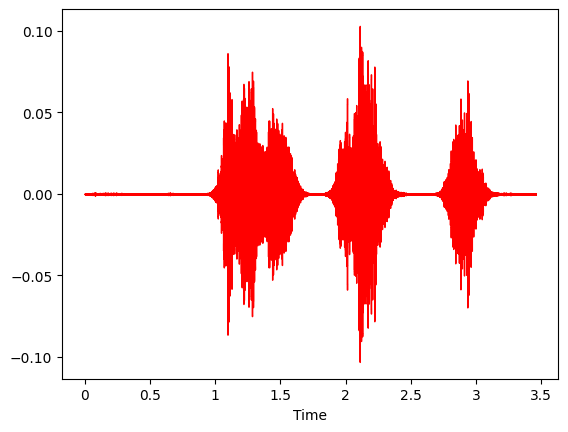

In [103]:
from scipy import signal

def GriffLim(spectrogram, N = 4096, h_part = 0.25, alpha = 0.97, i_max=16):
    h = int(N * h_part)
    new_spectrogram = spectrogram
    for i in range(i_max):
        X_t = librosa.istft(new_spectrogram, n_fft=N, hop_length=h)
        E = librosa.stft(X_t, n_fft=N, hop_length=h)
        Phi = E / np.abs(E)
        new_spectrogram = spectrogram * Phi
    X_t = librosa.istft(new_spectrogram, n_fft=N, hop_length=h)
    X_new = X_t.real
    if alpha > 0 and alpha < 1:
        X_new = signal.lfilter([1], [1, -alpha], X_new)
    return X_new

X_new = GriffLim(D)

# восстановленный сигнал
librosa.display.waveshow(X_new, sr=fd, color="red")

In [104]:
def calculate(signal, alpha = 0.97, N = 2048, h_part = 0.5, i_max = 64):
    D = prepare(signal, alpha, N, h_part, False)
    X_new = GriffLim(D, N, h_part, alpha, i_max)
    return X_new

1) Исследование влияния фильтра ВЧ

In [105]:
X_new = calculate(X, -1, 2048, 0.5, 64)
print("No filter :", np.mean((X[:len(X_new)] - X_new) ** 2))

for a in [0.95, 0.96, 0.97]:
    X_new = calculate(X, a, 2048, 0.5, 64)
    print(a, ":", np.mean((X[:len(X_new)] - X_new) ** 2))

No filter : 0.00019026922
0.95 : 0.00018915286291158861
0.96 : 0.00018982096389242792
0.97 : 0.0001905374309147162


Отсутствие фильтра высоких частот увеличивает СКО в 2.5 раза относительно случаев с применением фильтра, что говорит о его значимости. Изменение alpha в пределах 0.95-0.97 незначительно изменяет результат сравнения в худшую сторону. Остальные параметры были фиксированы.

2. Исследование влияния размерности дискретного преобразования Фурье

In [106]:
for N in [512, 1024, 2048, 4096]:
    X_new = calculate(X, 0.95, N, 0.5, 64)
    print(N, ":", np.mean((X[:len(X_new)] - X_new) ** 2))

512 : 0.00021404290058929897
1024 : 0.00020576805049091475
2048 : 0.00018915286291158861
4096 : 0.0001997956528882678


Наиболее оптимальный размер разбиения для данной задачи 2048.

3. Иследование влияния величины сдвига

In [107]:
for h_part in [0.25, 0.5, 1]:
    X_new = calculate(X, 0.95, 2048, h_part, 64)
    print(h_part, ":", np.mean((X[:len(X_new)] - X_new) ** 2))

0.25 : 0.0002300976156779856
0.5 : 0.00018915286291158861
1 : 486398.97667258576


Наиболее оптимальным из предложенных оказался сдвиг 1/2, при сдвиге 1 алгоритм отработал некорректно.

4. Исследование влияния числа итераций алгоритма

In [108]:
for i_max in [16, 32, 64, 128, 256]:
    X_new = calculate(X, 0.95, 2048, 0.5, i_max)
    print(i_max, ":", np.mean((X[:len(X_new)] - X_new) ** 2))

16 : 0.0001892289349651997
32 : 0.00018849371249955697
64 : 0.00018915286291158861
128 : 0.0001906591487931781
256 : 0.00019188801487891456


32 шага оказались наиболее оптимальными с небольшим перевесом.

### Вывод: наибольшее влияние на качество восстановления сигнала, которое в данном эксперименте определялось величиной СКО, оказали применение фильтра ВЧ и величина сдвига h.